# Cell-Specific Correlation Analysis for TRAF2 Hits

In [4]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from cmapPy.pandasGEXpress import parse
import scipy
import multiprocessing
import os
from joblib import Parallel, delayed

/Users/Nico/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Extract compound metadata

**NOTE THAT THERE ARE NO HIGH QUALITY (pct_self_rank < 0.05) SIGNATURES FOR NEGATIVE CONTROL BRD-K43131268**

In [29]:
# LINCS Phase 1 data
pert_info_1 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
pert_metrics_1 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_pert_metrics.txt', sep='\t', header=0)
sig_info_1 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_sig_info.txt', sep='\t', header=0, dtype={'pert_dose': float})
sig_metrics_1 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_sig_metrics.txt', sep='\t', header=0)
gene_info_1 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)

# LINCS Phase 2 data
pert_info_2a = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
sig_info_2 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt', sep='\t', header=0, dtype={'pert_dose': float})
sig_metrics_2 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE70138_Broad_LINCS_sig_metrics_2017-03-06.txt', sep='\t', header=0)

# Combine Phase 1 and Phase 2 data
pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True).reset_index(drop=True)
sig_info = pd.concat([sig_info_1, sig_info_2], ignore_index=True).reset_index(drop=True)
sig_metrics = pd.concat([sig_metrics_1, sig_metrics_2], ignore_index=True).reset_index(drop=True)

# For convenience, combine the sig_info and sig_metrics tables
sig_info = pd.concat([sig_info, sig_metrics[['distil_cc_q75', 'pct_self_rank_q25', 'tas']]], axis=1)

In [204]:
# extract sigs of interest
hit_names = ['BRD-A09719808', 'BRD-K95352812', 'BRD-K43131268' ]
all_hit_sigs = sig_info[sig_info.pert_id.isin(hit_names)]

In [44]:
# refine sigs
hi_q_hit_sigs = all_hit_sigs[all_hit_sigs.distil_cc_q75 >= 0.2]

In [64]:
# select representatives
repr_hit_sig_info_dict = {}
for cpd in hit_names:
    high_q_cpd_sigs = hi_q_hit_sigs[hi_q_hit_sigs.pert_id == cpd]
    repr_cpd_sigs_df = pd.DataFrame(columns=high_q_cpd_sigs.columns)
    for cell_line in high_q_cpd_sigs.cell_id.unique():
        candidate_sigs = high_q_cpd_sigs[high_q_cpd_sigs.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_cpd_sigs_df = repr_cpd_sigs_df.append(repr_sig)
    repr_hit_sig_info_dict[cpd] = repr_cpd_sigs_df

In [106]:
# find common cells
#common_cpd_cells = functools.reduce(set.intersection, [ set(repr_hit_sig_dict[c].cell_id.values) for c in hit_names ])
common_cpd_cells = {'A549', 'MCF7', 'PC3'}

# Extract kd metadata

In [70]:
# load all repr kd sigs
all_repr_kd_sig_info_dict = pickle.load(open('/Users/Nico/git/LINCS_target_prediction/checkpoint_files/repr_kd_sig_info_dict.sav', 'rb'))

In [72]:
# refine to NF-kB pathway genes with data for our common cell lines
pathway_genes = ['TRAF2','TRAF5','TRAF6','TNFRSF1A','TRADD','RIPK1','UBE2D1','BIRC2','BIRC3','UBB','UBC','UBA52','RPS27A','TAB2','TAB3','MAP3K7','IKBKG','RBCK1','CHUK','IKBKB','RELA','RELB','NFKBIA','NFKB1','NFKB2','CYLD','TNFAIP3']

In [110]:
repr_kd_sig_info_dict = {}
for g in pathway_genes:
    g_cells = set(all_repr_kd_sig_info_dict[g].cell_id)
    num_common_cells = len(g_cells.intersection(common_cpd_cells))
    if not num_common_cells < 3:
        repr_kd_sig_info_dict[g] = all_repr_kd_sig_info_dict[g]

# Extract gene expression sigs

In [76]:
# Load gene info
gene_info_1 = pd.read_csv('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

In [137]:
# Pull repr cpd sigs from the common cell lines
repr_common_cell_cpd_sigs = pd.DataFrame()
for pert_id in hit_names:
    repr_cpd_sigs = repr_hit_sig_info_dict[pert_id]
    repr_cpd_sigs = repr_cpd_sigs[repr_cpd_sigs.cell_id.isin(common_cpd_cells)]
    repr_common_cell_cpd_sigs = repr_common_cell_cpd_sigs.append(repr_cpd_sigs)
repr_common_cell_cpd_sigs = repr_common_cell_cpd_sigs.reset_index(drop=True)

In [138]:
# Pull repr kd sigs from the common cell lines
repr_common_cell_kd_sigs = pd.DataFrame()
for pert_iname, repr_kd_sigs in repr_kd_sig_info_dict.items():
    repr_kd_sigs = repr_kd_sigs[repr_kd_sigs.cell_id.isin(common_cpd_cells)]
    repr_common_cell_kd_sigs = repr_common_cell_kd_sigs.append(repr_kd_sigs)
repr_common_cell_kd_sigs = repr_common_cell_kd_sigs.reset_index(drop=True)

In [129]:
# Extract the actual cpd signatures
phase_1_sig_ids = parse('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values

# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
common_cell_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_common_cell_cpd_sigs.sig_id.values ]

# extract the actual signatures
raw_common_cell_cpd_sigs = parse('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=common_cell_cpd_sig_ids).data_df

# discard all but landmark gene values
common_cell_cpd_lm_sigs = raw_common_cell_cpd_sigs[raw_common_cell_cpd_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
common_cell_cpd_lm_sigs = common_cell_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
common_cell_cpd_lm_sigs.head()

cid,CPC007_A375_24H:BRD-K95352812-019-02-2:10,CPC007_A375_24H:BRD-A09719808-001-02-3:10,CPC007_A549_6H:BRD-K95352812-019-02-2:10,CPC007_A549_6H:BRD-A09719808-001-02-3:10,CPC007_HCC515_6H:BRD-K95352812-019-02-2:10,CPC007_HCC515_6H:BRD-A09719808-001-02-3:10,CPC007_MCF7_6H:BRD-K95352812-019-02-2:10,CPC007_MCF7_6H:BRD-A09719808-001-02-3:10,CPC007_PC3_6H:BRD-K95352812-019-02-2:10,CPC007_PC3_6H:BRD-A09719808-001-02-3:10,CPC007_VCAP_6H:BRD-K95352812-019-02-2:10,CPC007_VCAP_6H:BRD-A09719808-001-02-3:10,CPC010_A375_6H:BRD-K43131268-001-06-1:10,CPC010_A549_24H:BRD-K43131268-001-06-1:10,CPC010_HCC515_6H:BRD-K43131268-001-06-1:10,CPC010_MCF7_24H:BRD-K43131268-001-06-1:10,CPC010_PC3_24H:BRD-K43131268-001-06-1:10,CPC010_VCAP_6H:BRD-K43131268-001-06-1:10
rid,,,,,,,,,,,,,,,,,,
10007,5.444963,-3.850927,0.683448,-0.798622,-1.03930,-3.46920,0.533448,-1.790966,-1.369800,-1.445298,-0.350380,-1.461821,-0.712813,-0.35555,-1.496135,0.730868,-1.115601,-0.111001
1001,1.367809,1.117688,1.116135,-0.657993,-3.72095,0.01660,-0.735390,-0.856880,-1.900600,-0.312822,-0.018945,-0.140521,1.060463,0.40205,1.493772,0.049105,0.026951,0.302670
10013,-3.393312,-2.025197,-1.042782,0.333032,0.40905,0.95745,0.947595,1.126493,0.001644,-1.316680,0.333620,0.407949,0.548746,0.60610,0.409551,0.493622,-0.428259,-0.003610
10038,-4.776686,1.113620,-0.536143,1.709889,-3.37945,-4.21330,1.842275,1.260794,0.953981,-1.156833,-0.107278,-1.319288,-0.990518,0.42370,-1.920682,1.011621,-1.192842,-0.307122
10046,0.151283,1.703406,-0.250544,4.696206,1.02930,1.45860,0.018872,0.404227,-0.948246,0.623526,-0.027961,-0.431813,-0.595150,-0.10970,0.259204,2.030803,2.481228,0.232817


In [151]:
# Extract the actual KD signatures
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
common_cell_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_common_cell_kd_sigs.sig_id.values ]

# read in the data
common_cell_kd_raw_sigs = parse('/Users/Nico/git/LINCS_target_prediction/data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=common_cell_kd_sig_ids).data_df

# discard non-landmark gene expression scores
common_cell_kd_lm_sigs = common_cell_kd_raw_sigs[common_cell_kd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
common_cell_kd_lm_sigs = common_cell_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
common_cell_kd_lm_sigs.head()

cid,KDA001_A549_96H:TRCN0000001557:-666,KDA001_A549_96H:TRCN0000006520:-666,KDA001_A549_96H:TRCN0000014683:-666,KDA002_A549_96H:TRCN0000004540:-666,KDA006_A549_96H:TRCN0000050959:-666,KDA004_A549_96H:TRCN0000058717:-666,KDA002_A549_96H:TRCN0000008021:-666,KDA004_A549_96H:TRCN0000003384:-666,KDA001_MCF7_96H:TRCN0000001557:-666,KDA002_MCF7_96H:TRCN0000004539:-666,...,KDC010_MCF7_96H:TRCN0000007602:-666,KDC010_MCF7_96H:TRCN0000000707:-666,KDC010_MCF7_96H:TRCN0000004572:-666,KDC010_MCF7_96H:TRCN0000011109:-666,KDC010_PC3_96H:TRCN0000338176:-666,KDC010_PC3_96H:TRCN0000000707:-666,KDC010_PC3_96H:TRCN0000004572:-666,KDC010_PC3_96H:TRCN0000011107:-666,TAK002_PC3_96H:TRCN0000003782:-666,TAK001_PC3_96H:TRCN0000014683:-666
rid,,,,,,,,,,,,,,,,,,,,,
10007,0.336048,-4.025105,0.143342,-2.684912,0.572432,-2.259830,0.757877,0.065917,-0.030928,0.916873,...,0.649187,-0.385142,-1.195790,0.020154,0.29185,-1.60220,-0.40260,0.6927,0.077791,-1.74815
1001,0.710651,1.221760,-1.419263,1.408325,-0.376282,0.341548,-0.155927,-0.323013,-0.661080,1.220203,...,-0.473438,0.143067,0.178425,1.030521,-3.62840,-0.03975,0.12835,0.0222,1.054010,0.06805
10013,1.020767,1.624078,-0.420408,-0.411031,0.231836,0.067098,-0.826539,0.661043,1.194081,0.162356,...,-0.150834,-1.501032,-0.319643,-0.538124,-0.47160,-2.90650,-0.17575,-0.3720,-1.262656,-1.51695
10038,-1.435064,-1.120671,-0.410621,-0.091708,0.246928,-0.292399,-0.101792,-1.203306,-0.975577,-1.922594,...,-1.141932,0.093505,-1.478549,-1.595316,-1.01850,-0.53245,-0.76460,0.9212,-1.628627,0.01850
10046,1.278399,1.322854,1.067577,0.816714,-0.771265,1.398324,-0.232954,0.456450,0.819874,1.250894,...,3.632895,-0.034778,1.149219,0.314449,1.16600,0.45120,-0.03540,-0.0093,3.182007,0.14665


# Calculate cell-specific correlations

## 1. A549

In [210]:
cell_cpd_sigs = repr_common_cell_cpd_sigs[repr_common_cell_cpd_sigs.cell_id == 'A549']
cell_kd_sigs = repr_common_cell_kd_sigs[repr_common_cell_kd_sigs.cell_id == 'A549']

# initialize results df
cpds = ['BRD-A09719808', 'BRD-K95352812', 'BRD-K43131268' ]
genes = cell_kd_sigs.pert_iname.values.astype(str)
A549_corrs = pd.DataFrame(index=cpds, columns=genes)

# calculate correlations
for cpd in cpds:
    sig_id = cell_cpd_sigs[cell_cpd_sigs.pert_id == cpd].sig_id
    cpd_sig = common_cell_cpd_lm_sigs[sig_id]

    for gene in genes:
        gene_sig_id = cell_kd_sigs[cell_kd_sigs.pert_iname == gene].sig_id
        gene_sig = common_cell_kd_lm_sigs[gene_sig_id]
        rho = scipy.stats.pearsonr(cpd_sig, gene_sig)[0][0]
        
        A549_corrs.at[cpd, gene] = float(rho)

A549_corrs = A549_corrs[A549_corrs.columns].astype(float)

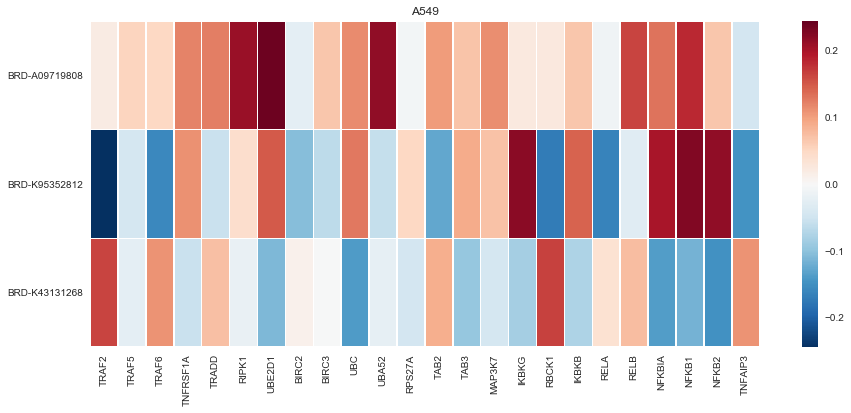

In [216]:
sns.set()
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(A549_corrs, linewidths=.5, ax=ax)
plt.title("A549")
plt.yticks(rotation=0)
plt.show()

## 2. MCF7

In [217]:
cell_cpd_sigs = repr_common_cell_cpd_sigs[repr_common_cell_cpd_sigs.cell_id == 'MCF7']
cell_kd_sigs = repr_common_cell_kd_sigs[repr_common_cell_kd_sigs.cell_id == 'MCF7']

# initialize results df
cpds = ['BRD-A09719808', 'BRD-K95352812', 'BRD-K43131268' ]
genes = cell_kd_sigs.pert_iname.values.astype(str)
MCF7_corrs = pd.DataFrame(index=cpds, columns=genes)

# calculate correlations
for cpd in cpds:
    sig_id = cell_cpd_sigs[cell_cpd_sigs.pert_id == cpd].sig_id
    cpd_sig = common_cell_cpd_lm_sigs[sig_id]

    for gene in genes:
        gene_sig_id = cell_kd_sigs[cell_kd_sigs.pert_iname == gene].sig_id
        gene_sig = common_cell_kd_lm_sigs[gene_sig_id]
        rho = scipy.stats.pearsonr(cpd_sig, gene_sig)[0][0]
        
        MCF7_corrs.at[cpd, gene] = float(rho)

MCF7_corrs = MCF7_corrs[MCF7_corrs.columns].astype(float)

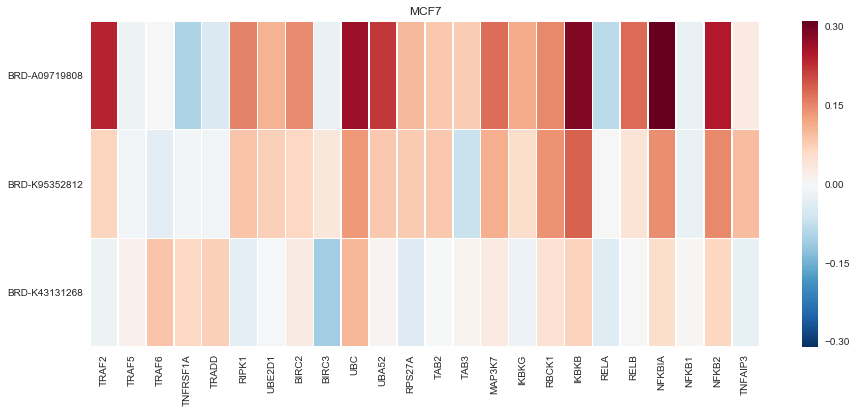

In [218]:
sns.set()
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(MCF7_corrs, linewidths=.5, ax=ax)
plt.title("MCF7")
plt.yticks(rotation=0)
plt.show()

## 3. PC3

In [219]:
cell_cpd_sigs = repr_common_cell_cpd_sigs[repr_common_cell_cpd_sigs.cell_id == 'PC3']
cell_kd_sigs = repr_common_cell_kd_sigs[repr_common_cell_kd_sigs.cell_id == 'PC3']

# initialize results df
cpds = ['BRD-A09719808', 'BRD-K95352812', 'BRD-K43131268' ]
genes = cell_kd_sigs.pert_iname.values.astype(str)
PC3_corrs = pd.DataFrame(index=cpds, columns=genes)

# calculate correlations
for cpd in cpds:
    sig_id = cell_cpd_sigs[cell_cpd_sigs.pert_id == cpd].sig_id
    cpd_sig = common_cell_cpd_lm_sigs[sig_id]

    for gene in genes:
        gene_sig_id = cell_kd_sigs[cell_kd_sigs.pert_iname == gene].sig_id
        gene_sig = common_cell_kd_lm_sigs[gene_sig_id]
        rho = scipy.stats.pearsonr(cpd_sig, gene_sig)[0][0]
        
        PC3_corrs.at[cpd, gene] = float(rho)

PC3_corrs = PC3_corrs[PC3_corrs.columns].astype(float)

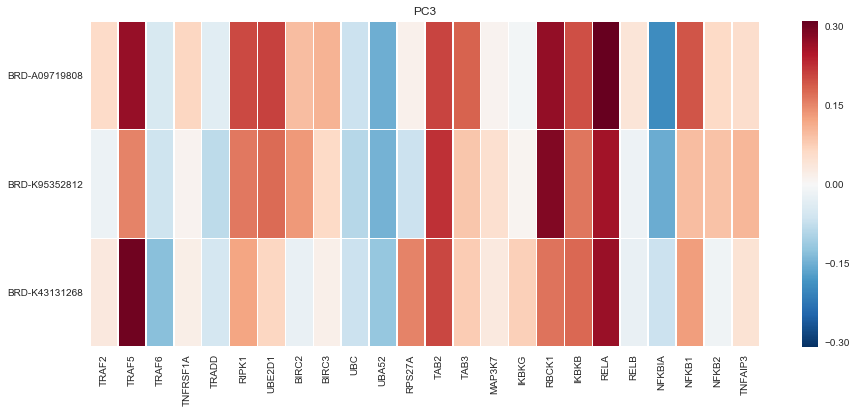

In [220]:
sns.set()
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(PC3_corrs, linewidths=.5, ax=ax)
plt.title("PC3")
plt.yticks(rotation=0)
plt.show()